In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interest rate

In [2]:
stir = pd.read_csv('var/short_term_int_rate_q.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['date'] = pd.to_datetime(stir['TIME'])

#### inflation rate

In [5]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()
ir = ir[:-9]
ir = [float(ir[i]) for i in range(len(ir))]
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

In [6]:
ir = ir.iloc[:-3, :].copy()

In [7]:
ir['date'] = ir['TIME'].map(lambda x: pd.Period(x,'Q'))

In [8]:
ir = ir[['date', 'Value']].copy()

In [9]:
ir['Value'] = ir['Value'].astype(float)

In [10]:
ir['date'] = ir['date'].astype(str)

In [11]:
quarters = pd.unique(ir['date']).tolist()

In [12]:
g = ir.groupby('date')['Value']

In [13]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [14]:
ir = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [15]:
gdp = pd.read_csv('var/gdp_m_q.csv')

In [16]:
gdp = gdp[
    gdp['Subject']=='National Accounts > GDP by Expenditure > Constant Prices > Gross Domestic Product - Total'
].copy()

In [17]:
gdp = gdp[gdp['Measure']=='Level, rate or national currency, s.a.'].copy()

In [18]:
gdp = gdp[gdp['FREQUENCY']=='Q'].copy()

In [19]:
gdp = gdp[['Subject', 'Measure', 'FREQUENCY', 'TIME', 'Time', 'Unit Code', 'Value']].copy()

In [20]:
gdp = gdp.reset_index(drop=True)

In [21]:
gdp = gdp[['TIME', 'Value']].copy()

In [22]:
gdp['date'] = pd.to_datetime(gdp['TIME']).tolist()

#### Make full DF

In [23]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()

In [24]:
stir.index = stir['date']
stir = stir[['Value']].copy()

In [25]:
ir.index = ir['date']
ir = ir[['Value']].copy()

In [26]:
df_var_t = pd.concat([gdp, stir, ir], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

## Stationarity part

Results of Dickey-Fuller Test:
Test Statistic                   1.137740
p-value                          0.995526
#Lags Used                       2.000000
Number of Observations Used    207.000000
Critical Value (10%)            -2.574267
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
dtype: float64


Results of KPSS Test:
Test Statistic            1.407291
p-value                   0.010000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


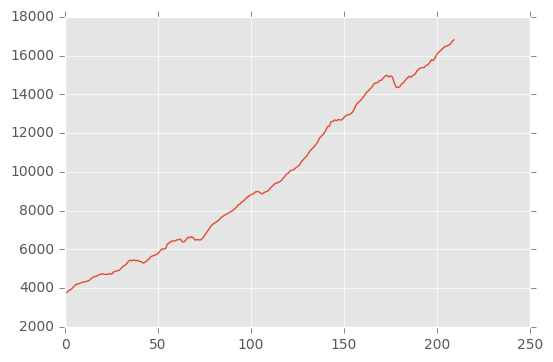

In [27]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.754592
p-value                          0.403227
#Lags Used                       7.000000
Number of Observations Used    202.000000
Critical Value (10%)            -2.574455
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
dtype: float64


Results of KPSS Test:
Test Statistic            0.805212
p-value                   0.010000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


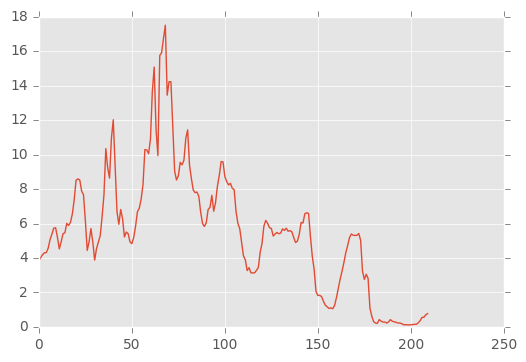

In [28]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.628578
p-value                          0.468235
#Lags Used                      12.000000
Number of Observations Used    197.000000
Critical Value (10%)            -2.574652
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
dtype: float64


Results of KPSS Test:
Test Statistic            0.627924
p-value                   0.020098
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


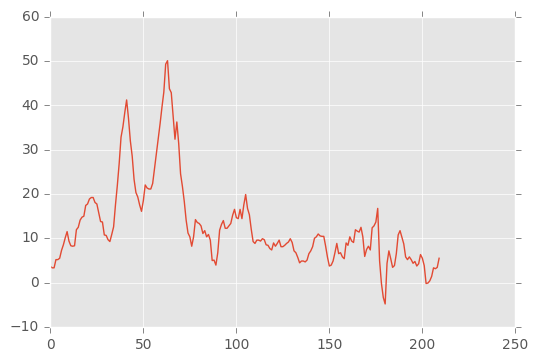

In [29]:
test_stationarity(df_var_t['infr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                -6.729151e+00
p-value                        3.330094e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (10%)          -2.574267e+00
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.305495
p-value                   0.100000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


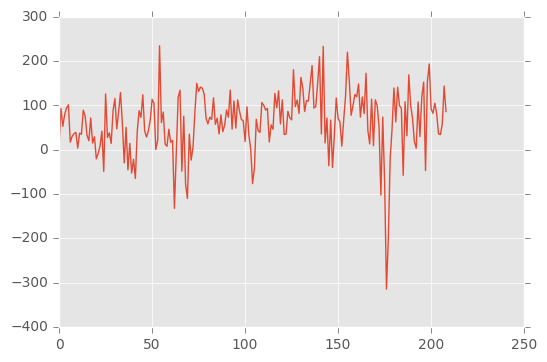

In [30]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -5.919963e+00
p-value                        2.520096e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (10%)          -2.574455e+00
Critical Value (1%)           -3.463144e+00
Critical Value (5%)           -2.875957e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.120741
p-value                   0.100000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


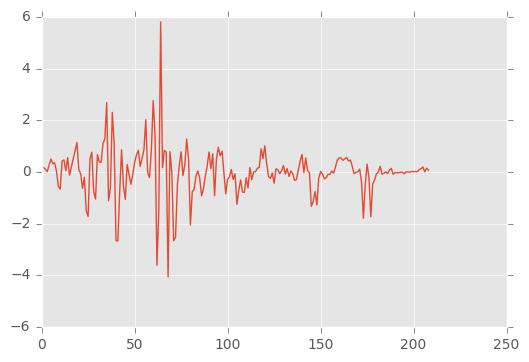

In [31]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.493664
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    193.000000
Critical Value (10%)            -2.574816
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
dtype: float64


Results of KPSS Test:
Test Statistic            0.110707
p-value                   0.100000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


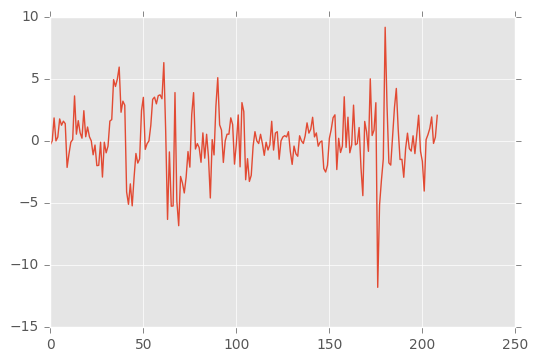

In [32]:
test_stationarity(diff_series(df_var_t['infr']))

In [33]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [34]:
STEPS = 8
LAG = 2

In [35]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [36]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [37]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'rmse': 0.10996149047750971, 'mae': 0.090445068635786136, 'mse': 0.012091529388035458}
{'rmse': 1.7059748886677861, 'mae': 1.1775344467659377, 'mse': 2.9103503207650654}
{'rmse': 36.506504399532353, 'mae': 28.660567429660091, 'mse': 1332.7248634730749}


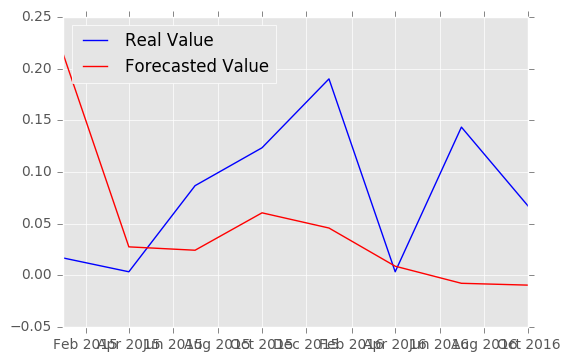

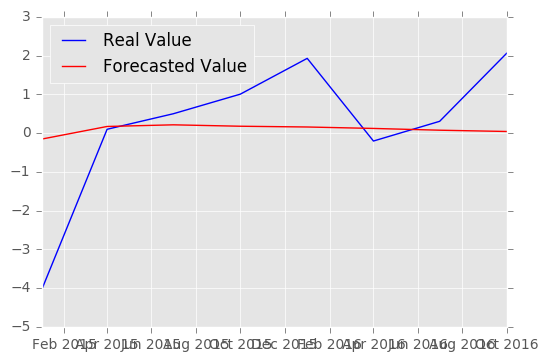

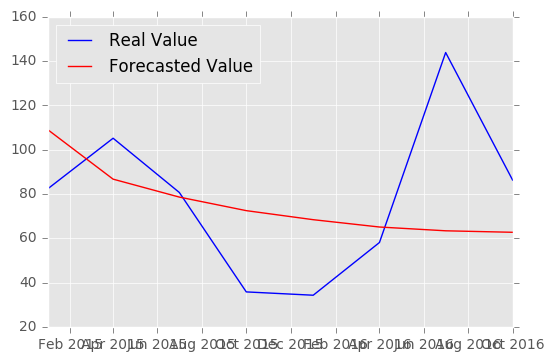

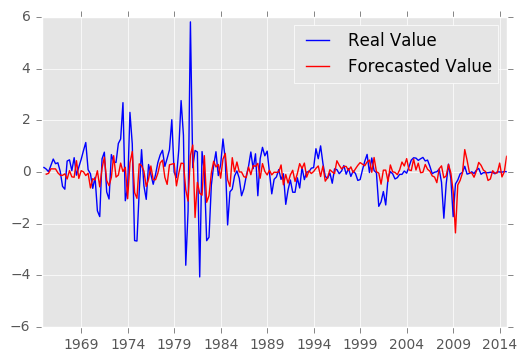

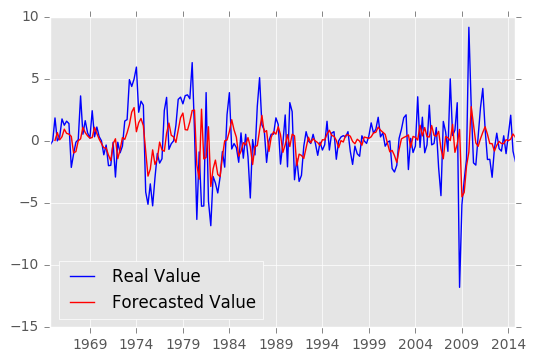

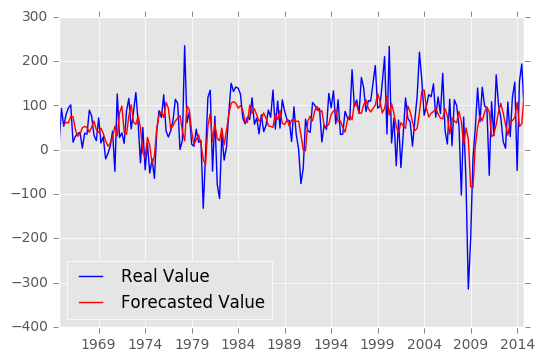

In [38]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'rmse': 0.17222216123280557, 'mae': 0.15367499917124317, 'mse': 0.029660472819698476}
{'rmse': 2.6869493293725872, 'mae': 2.3610527229720599, 'mse': 7.2196966986157971}
{'rmse': 44.856349547121575, 'mae': 33.639687728436684, 'mse': 2012.0920946935539}


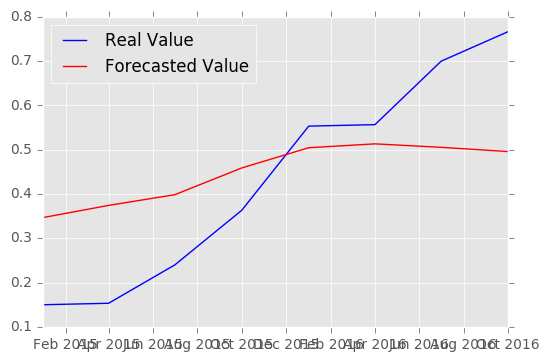

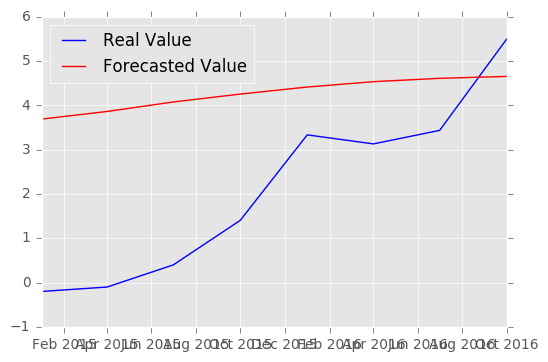

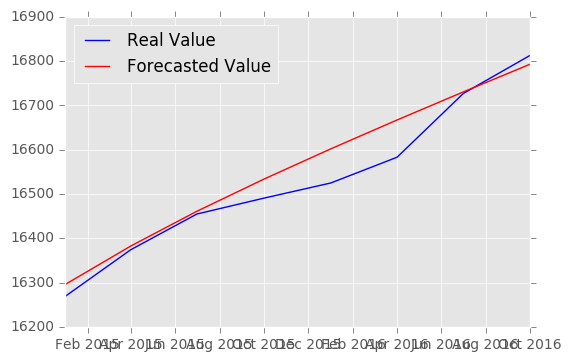

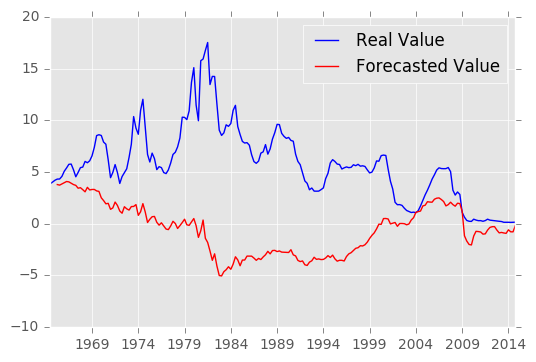

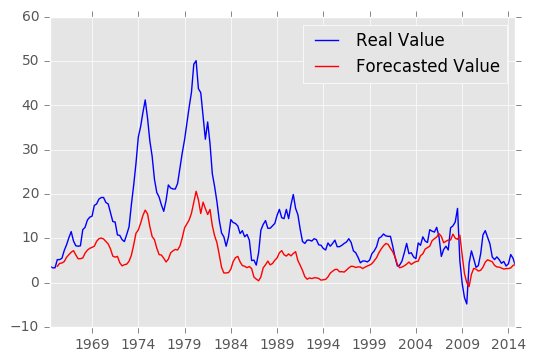

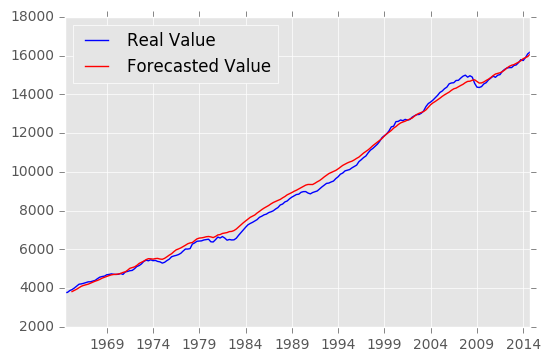

In [39]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [40]:
df_nn = nn_transform(train, n=LAG)

In [41]:
df_nn_s, m, s = scaler(df_nn)

In [42]:
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [43]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [44]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [45]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1196
Epoch 2/600
0s - loss: 0.9997
Epoch 3/600
0s - loss: 0.9861
Epoch 4/600
0s - loss: 0.9774
Epoch 5/600
0s - loss: 0.9662
Epoch 6/600
0s - loss: 0.9577
Epoch 7/600
0s - loss: 0.9503
Epoch 8/600
0s - loss: 0.9433
Epoch 9/600
0s - loss: 0.9289
Epoch 10/600
0s - loss: 0.9210
Epoch 11/600
0s - loss: 0.9108
Epoch 12/600
0s - loss: 0.9035
Epoch 13/600
0s - loss: 0.8949
Epoch 14/600
0s - loss: 0.8872
Epoch 15/600
0s - loss: 0.8794
Epoch 16/600
0s - loss: 0.8744
Epoch 17/600
0s - loss: 0.8683
Epoch 18/600
0s - loss: 0.8629
Epoch 19/600
0s - loss: 0.8575
Epoch 20/600
0s - loss: 0.8521
Epoch 21/600
0s - loss: 0.8493
Epoch 22/600
0s - loss: 0.8468
Epoch 23/600
0s - loss: 0.8406
Epoch 24/600
0s - loss: 0.8381
Epoch 25/600
0s - loss: 0.8369
Epoch 26/600
0s - loss: 0.8305
Epoch 27/600
0s - loss: 0.8284
Epoch 28/600
0s - loss: 0.8274
Epoch 29/600
0s - loss: 0.8228
Epoch 30/600
0s - loss: 0.8209
Epoch 31/600
0s - loss: 0.8202
Epoch 32/600
0s - loss: 0.8166
Epoch 33/600
0s -

In [46]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

{'rmse': 0.21671956377487947, 'mae': 0.16948209706449763, 'mse': 0.046967369322774052}
{'rmse': 1.3891107593571026, 'mae': 1.1966113779260148, 'mse': 1.9296287017616662}
{'rmse': 39.26818196109847, 'mae': 34.753223657674312, 'mse': 1541.9901145299395}


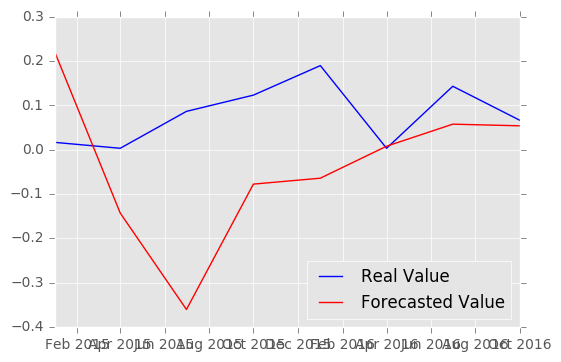

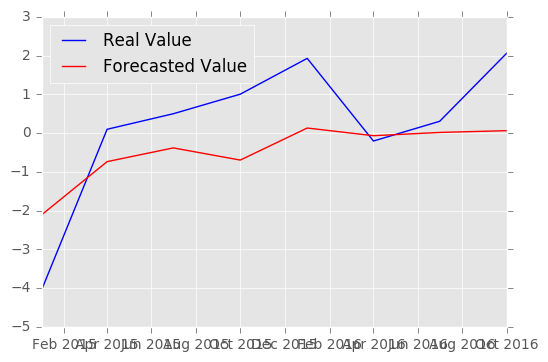

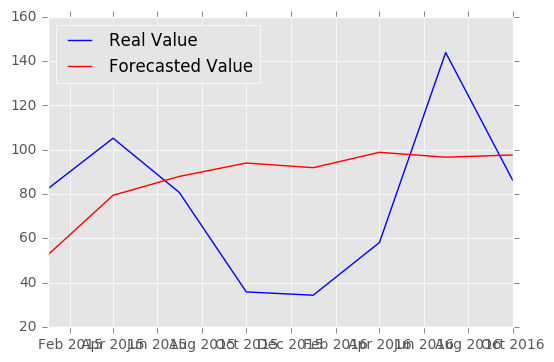

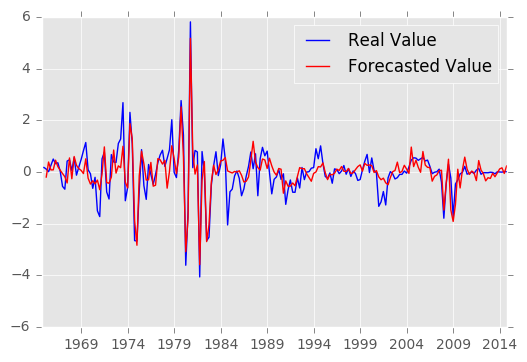

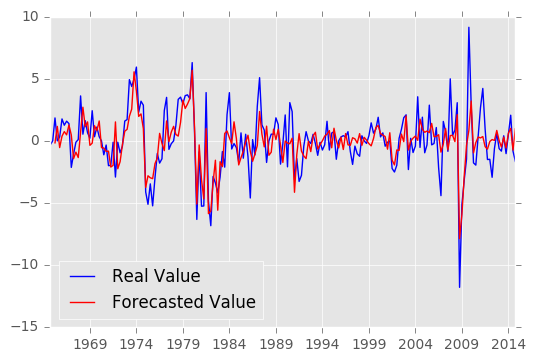

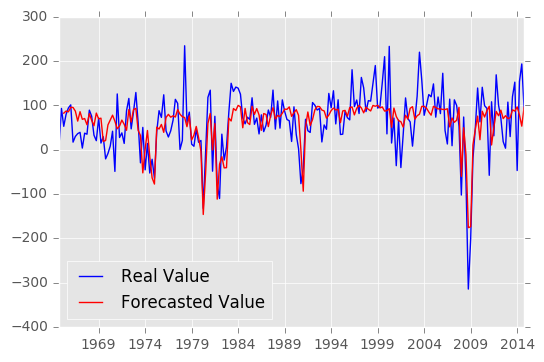

In [47]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'rmse': 0.68013783585907039, 'mae': 0.59876079437000373, 'mse': 0.46258747576705977}
{'rmse': 2.9366527087411787, 'mae': 2.5014065097709892, 'mse': 8.6239291317569027}
{'rmse': 62.832282489429893, 'mae': 56.543083073261187, 'mse': 3947.8957228315185}


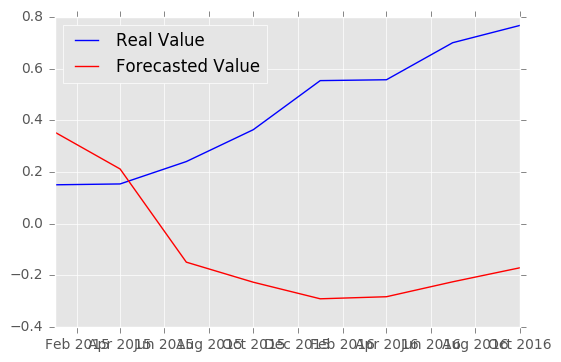

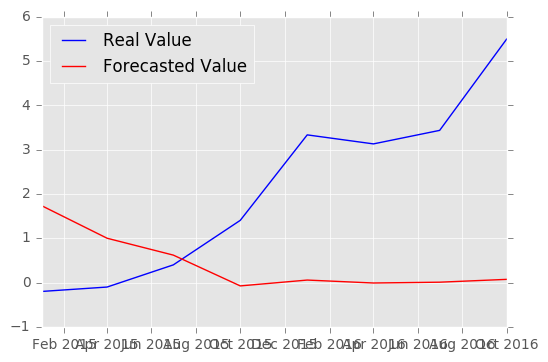

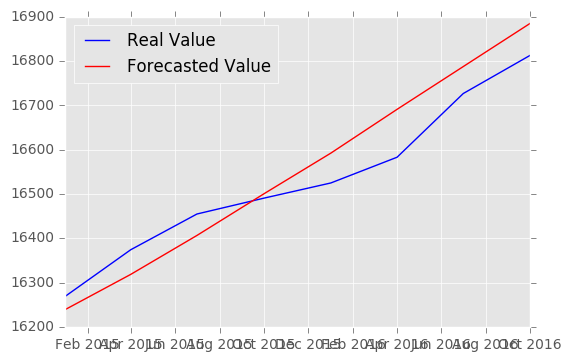

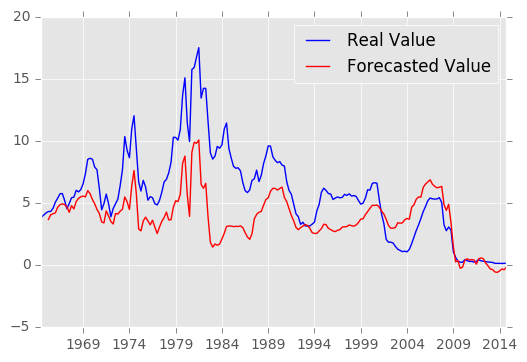

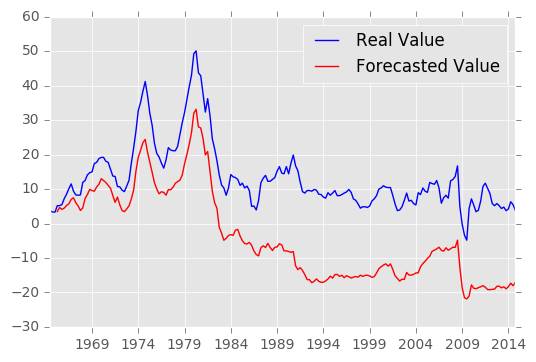

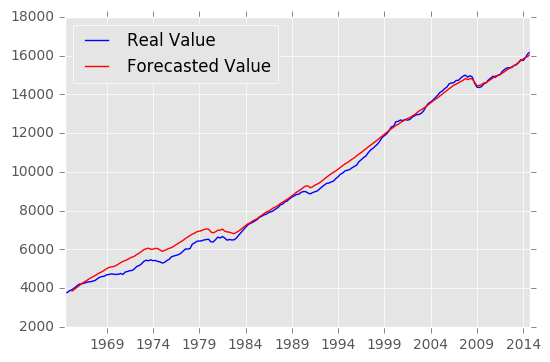

In [48]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [49]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1728
Epoch 2/600
0s - loss: 0.9939
Epoch 3/600
0s - loss: 0.9704
Epoch 4/600
0s - loss: 0.9576
Epoch 5/600
0s - loss: 0.9448
Epoch 6/600
0s - loss: 0.9320
Epoch 7/600
0s - loss: 0.9218
Epoch 8/600
0s - loss: 0.9089
Epoch 9/600
0s - loss: 0.8981
Epoch 10/600
0s - loss: 0.8870
Epoch 11/600
0s - loss: 0.8796
Epoch 12/600
0s - loss: 0.8720
Epoch 13/600
0s - loss: 0.8676
Epoch 14/600
0s - loss: 0.8598
Epoch 15/600
0s - loss: 0.8541
Epoch 16/600
0s - loss: 0.8503
Epoch 17/600
0s - loss: 0.8457
Epoch 18/600
0s - loss: 0.8426
Epoch 19/600
0s - loss: 0.8380
Epoch 20/600
0s - loss: 0.8319
Epoch 21/600
0s - loss: 0.8320
Epoch 22/600
0s - loss: 0.8276
Epoch 23/600
0s - loss: 0.8263
Epoch 24/600
0s - loss: 0.8236
Epoch 25/600
0s - loss: 0.8218
Epoch 26/600
0s - loss: 0.8180
Epoch 27/600
0s - loss: 0.8176
Epoch 28/600
0s - loss: 0.8148
Epoch 29/600
0s - loss: 0.8108
Epoch 30/600
0s - loss: 0.8110
Epoch 31/600
0s - loss: 0.8094
Epoch 32/600
0s - loss: 0.8069
Epoch 33/600
0s -

{'rmse': 0.40242516428127212, 'mae': 0.31698679164684002, 'mse': 0.16194601284680885}
{'rmse': 1.7470460208883152, 'mae': 1.3265687024867492, 'mse': 3.0521697991016952}
{'rmse': 33.426576533293137, 'mae': 25.265008231810036, 'mse': 1117.3360187361036}


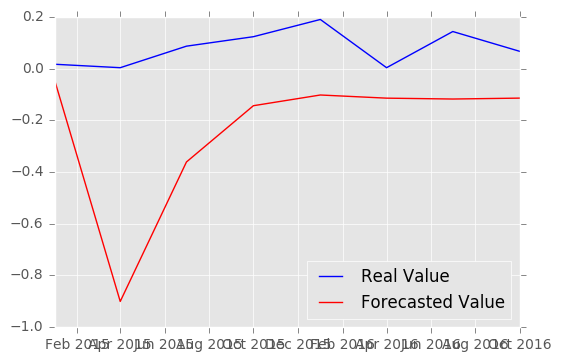

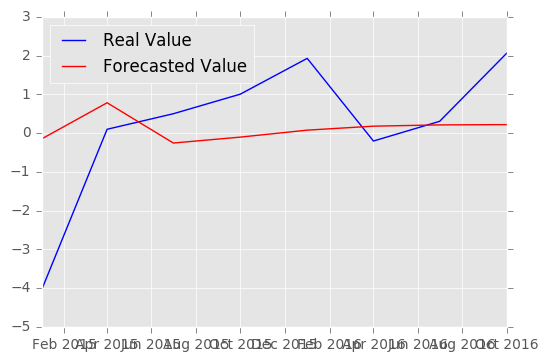

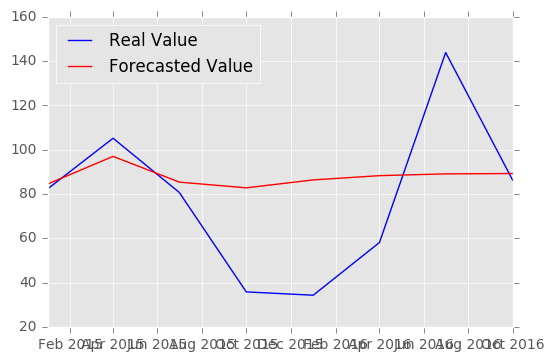

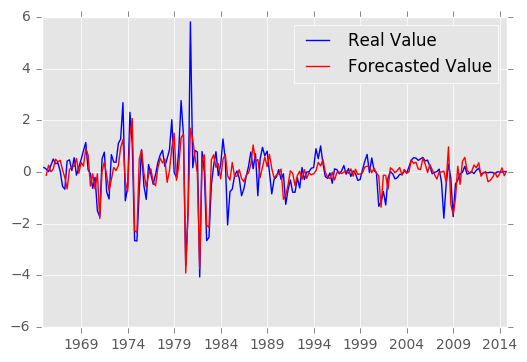

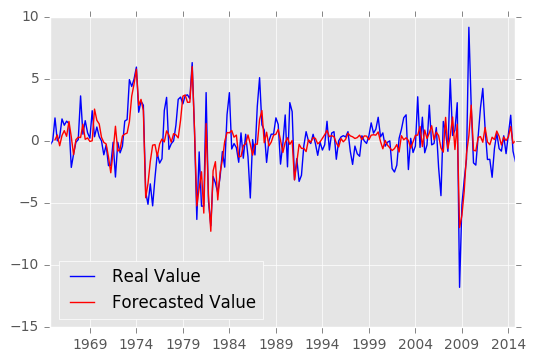

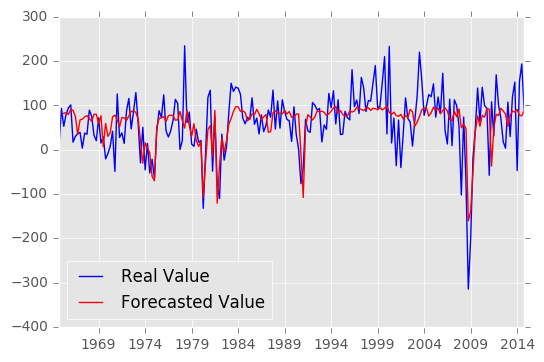

In [50]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'rmse': 1.8042076235733135, 'mae': 1.6362502274356001, 'mse': 3.2551651489600637}
{'rmse': 2.7899568662713241, 'mae': 2.3710227530415402, 'mse': 7.7838593156545075}
{'rmse': 70.015304498593608, 'mae': 53.780358900148485, 'mse': 4902.1428640307813}


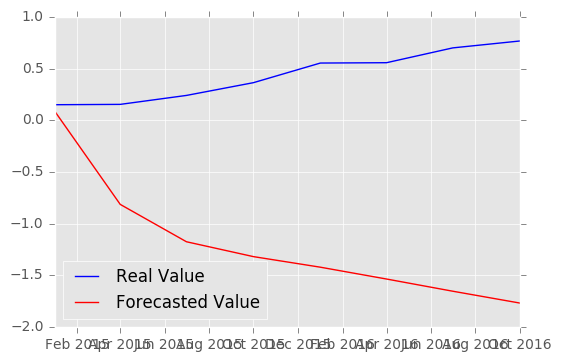

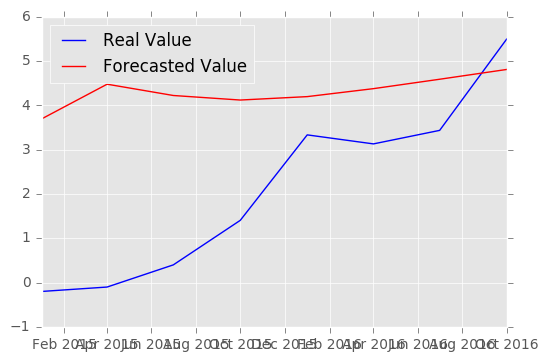

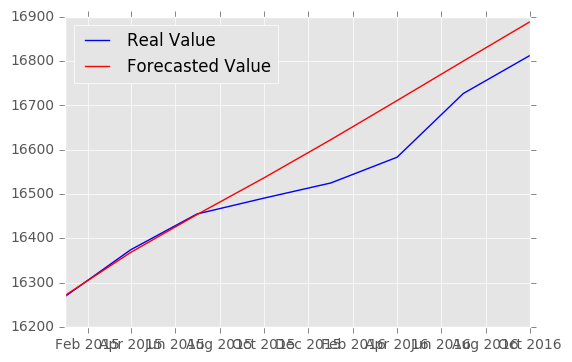

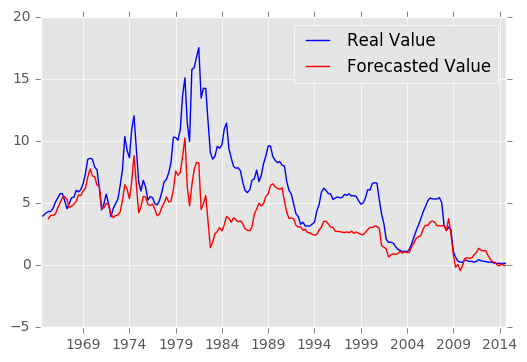

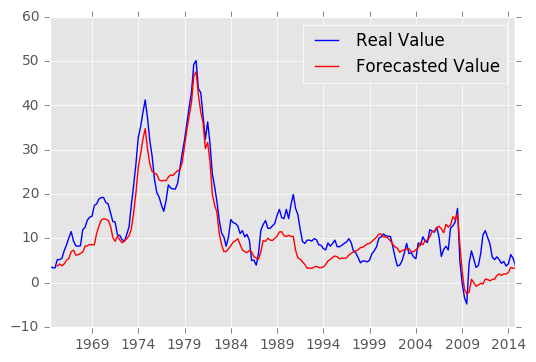

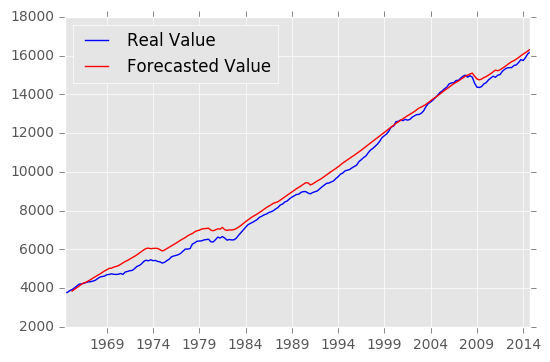

In [51]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [52]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0257
Epoch 2/600
0s - loss: 1.0238
Epoch 3/600
0s - loss: 1.0259
Epoch 4/600
0s - loss: 1.0016
Epoch 5/600
0s - loss: 1.0010
Epoch 6/600
0s - loss: 1.0315
Epoch 7/600
0s - loss: 1.0098
Epoch 8/600
0s - loss: 1.0004
Epoch 9/600
0s - loss: 0.9955
Epoch 10/600
0s - loss: 0.9984
Epoch 11/600
0s - loss: 0.9961
Epoch 12/600
0s - loss: 0.9910
Epoch 13/600
0s - loss: 0.9813
Epoch 14/600
0s - loss: 0.9809
Epoch 15/600
0s - loss: 0.9716
Epoch 16/600
0s - loss: 0.9847
Epoch 17/600
0s - loss: 0.9747
Epoch 18/600
0s - loss: 0.9821
Epoch 19/600
0s - loss: 0.9735
Epoch 20/600
0s - loss: 0.9401
Epoch 21/600
0s - loss: 0.9659
Epoch 22/600
0s - loss: 0.9718
Epoch 23/600
0s - loss: 0.9763
Epoch 24/600
0s - loss: 0.9621
Epoch 25/600
0s - loss: 0.9491
Epoch 26/600
0s - loss: 0.9726
Epoch 27/600
0s - loss: 0.9612
Epoch 28/600
0s - loss: 0.9549
Epoch 29/600
0s - loss: 0.9383
Epoch 30/600
0s - loss: 0.9559
Epoch 31/600
0s - loss: 0.9348
Epoch 32/600
0s - loss: 0.9367
Epoch 33/600
0s -

{'rmse': 0.1231576282352968, 'mae': 0.10140600748538245, 'mse': 0.015167801392543576}
{'rmse': 1.7431609399587888, 'mae': 1.1467826147569846, 'mse': 3.0386100625980084}
{'rmse': 36.662153837837629, 'mae': 30.115514281949181, 'mse': 1344.1135240292724}


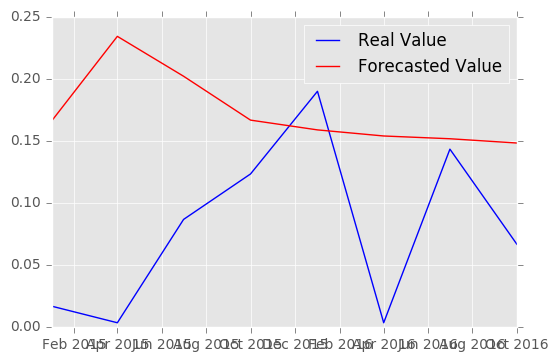

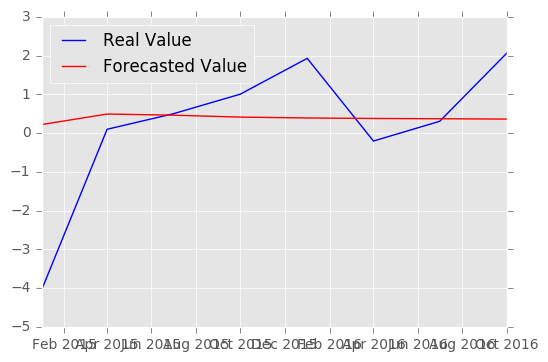

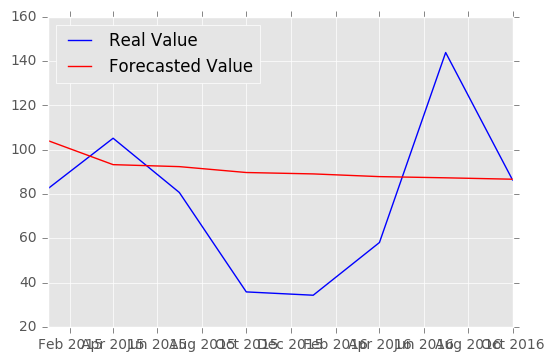

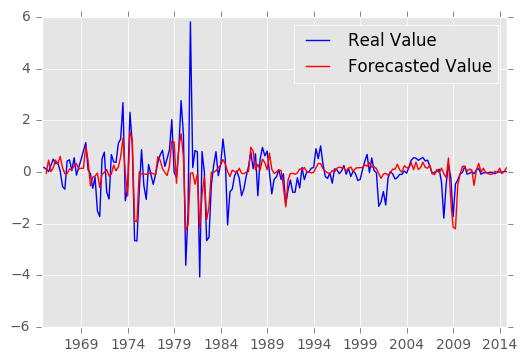

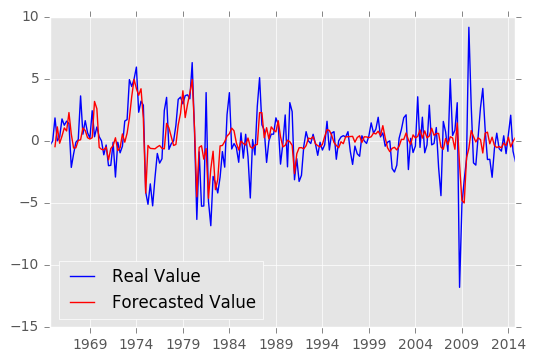

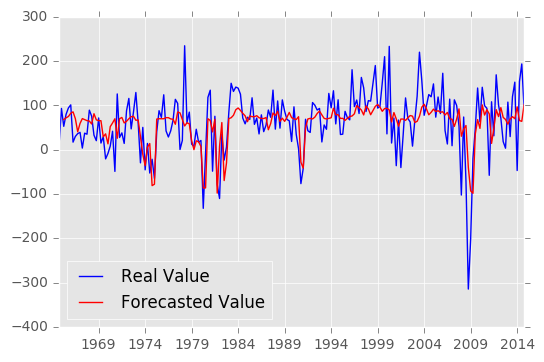

In [53]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'rmse': 0.54810993439586853, 'mae': 0.51868216657706867, 'mse': 0.30042450018344324}
{'rmse': 3.62631206384581, 'mae': 3.4674555956449433, 'mse': 13.150139184393657}
{'rmse': 94.131019646137858, 'mae': 78.35897610828215, 'mse': 8860.6488596215913}


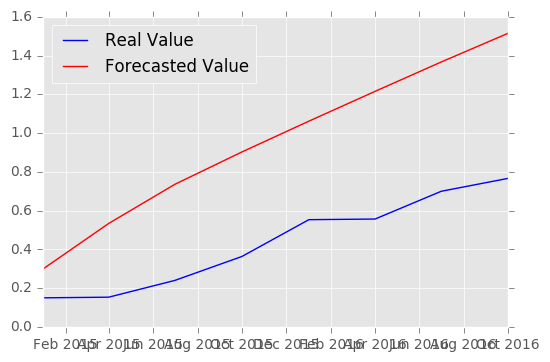

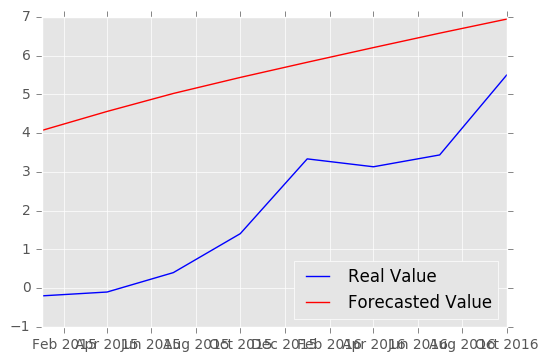

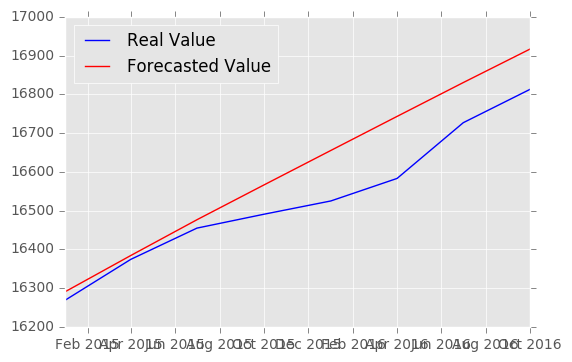

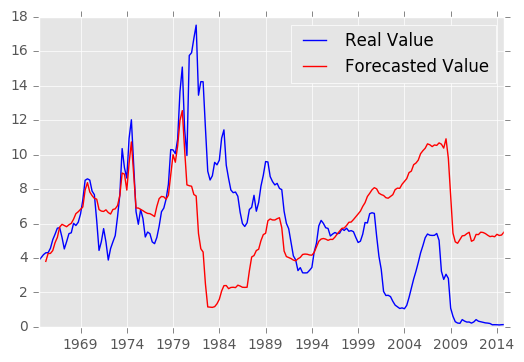

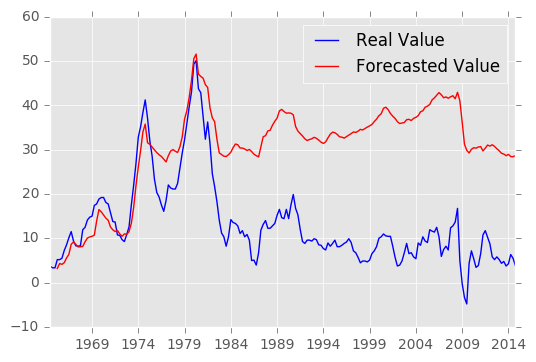

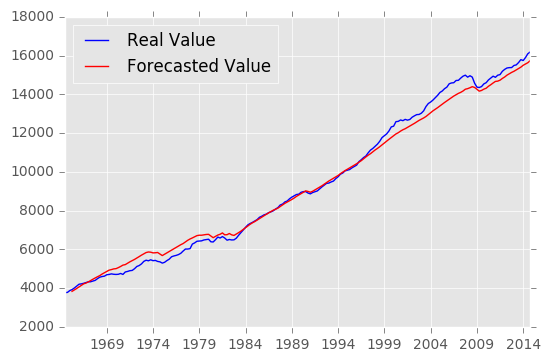

In [54]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [55]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [56]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1384
Epoch 2/600
0s - loss: 0.8412
Epoch 3/600
0s - loss: 0.7025
Epoch 4/600
0s - loss: 0.5749
Epoch 5/600
0s - loss: 0.4746
Epoch 6/600
0s - loss: 0.4081
Epoch 7/600
0s - loss: 0.3662
Epoch 8/600
0s - loss: 0.3370
Epoch 9/600
0s - loss: 0.3123
Epoch 10/600
0s - loss: 0.2874
Epoch 11/600
0s - loss: 0.2627
Epoch 12/600
0s - loss: 0.2382
Epoch 13/600
0s - loss: 0.2149
Epoch 14/600
0s - loss: 0.1944
Epoch 15/600
0s - loss: 0.1770
Epoch 16/600
0s - loss: 0.1614
Epoch 17/600
0s - loss: 0.1491
Epoch 18/600
0s - loss: 0.1384
Epoch 19/600
0s - loss: 0.1288
Epoch 20/600
0s - loss: 0.1194
Epoch 21/600
0s - loss: 0.1111
Epoch 22/600
0s - loss: 0.1034
Epoch 23/600
0s - loss: 0.0963
Epoch 24/600
0s - loss: 0.0896
Epoch 25/600
0s - loss: 0.0826
Epoch 26/600
0s - loss: 0.0781
Epoch 27/600
0s - loss: 0.0735
Epoch 28/600
0s - loss: 0.0700
Epoch 29/600
0s - loss: 0.0663
Epoch 30/600
0s - loss: 0.0633
Epoch 31/600
0s - loss: 0.0609
Epoch 32/600
0s - loss: 0.0587
Epoch 33/600
0s -

{'rmse': 7.8804917035289206, 'mae': 7.8491499909246558, 'mse': 62.102149489388147}
{'rmse': 16.013285799868559, 'mae': 14.802144851055074, 'mse': 256.42532210827198}
{'rmse': 2682.8255760104271, 'mae': 2391.1933384016133, 'mse': 7197553.0712956795}


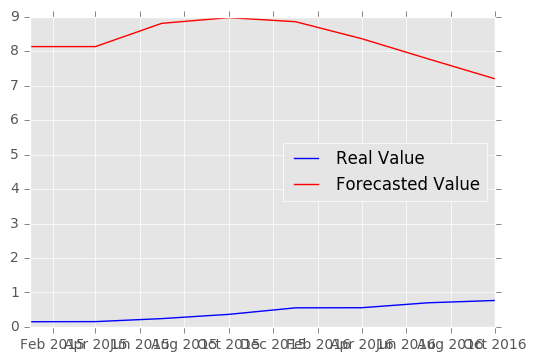

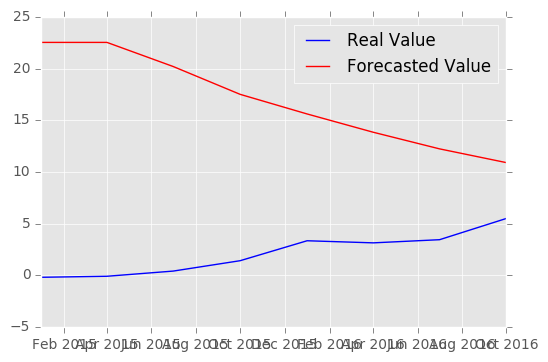

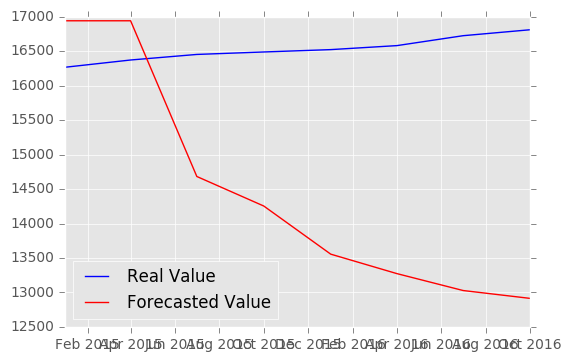

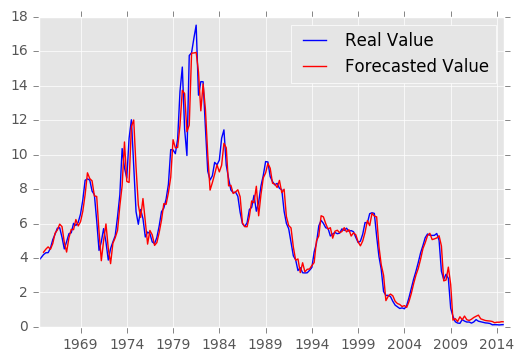

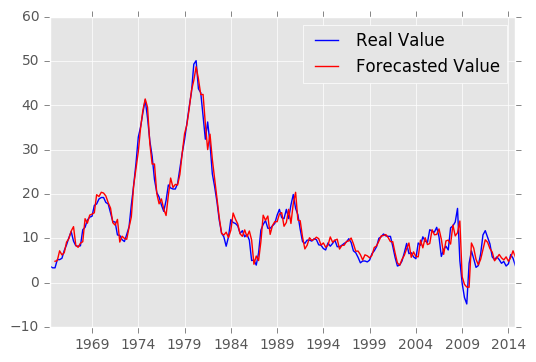

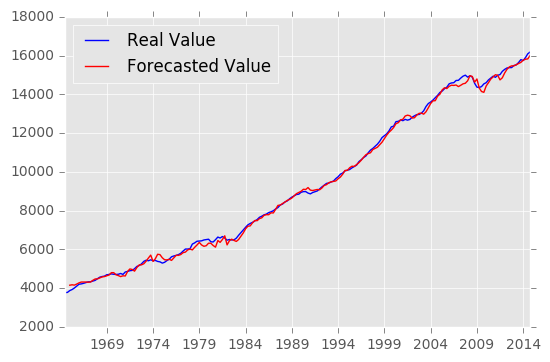

In [57]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [58]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0749
Epoch 2/600
0s - loss: 0.9076
Epoch 3/600
0s - loss: 0.8170
Epoch 4/600
0s - loss: 0.7141
Epoch 5/600
0s - loss: 0.5938
Epoch 6/600
0s - loss: 0.4828
Epoch 7/600
0s - loss: 0.3927
Epoch 8/600
0s - loss: 0.3254
Epoch 9/600
0s - loss: 0.2789
Epoch 10/600
0s - loss: 0.2413
Epoch 11/600
0s - loss: 0.2114
Epoch 12/600
0s - loss: 0.1861
Epoch 13/600
0s - loss: 0.1640
Epoch 14/600
0s - loss: 0.1469
Epoch 15/600
0s - loss: 0.1317
Epoch 16/600
0s - loss: 0.1194
Epoch 17/600
0s - loss: 0.1097
Epoch 18/600
0s - loss: 0.1004
Epoch 19/600
0s - loss: 0.0934
Epoch 20/600
0s - loss: 0.0879
Epoch 21/600
0s - loss: 0.0825
Epoch 22/600
0s - loss: 0.0778
Epoch 23/600
0s - loss: 0.0743
Epoch 24/600
0s - loss: 0.0713
Epoch 25/600
0s - loss: 0.0685
Epoch 26/600
0s - loss: 0.0668
Epoch 27/600
0s - loss: 0.0654
Epoch 28/600
0s - loss: 0.0635
Epoch 29/600
0s - loss: 0.0631
Epoch 30/600
0s - loss: 0.0610
Epoch 31/600
0s - loss: 0.0602
Epoch 32/600
0s - loss: 0.0596
Epoch 33/600
0s -

{'rmse': 1.1627113252178962, 'mae': 0.70352785698325038, 'mse': 1.3518976257899566}
{'rmse': 9.4785081813417502, 'mae': 6.442523525084848, 'mse': 89.842117343762496}
{'rmse': 1954.5373659801817, 'mae': 1480.1504715834035, 'mse': 3820216.3150127465}


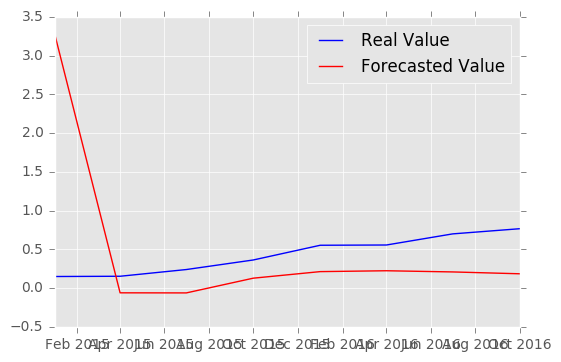

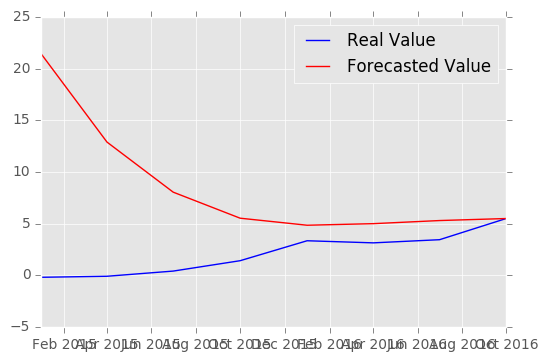

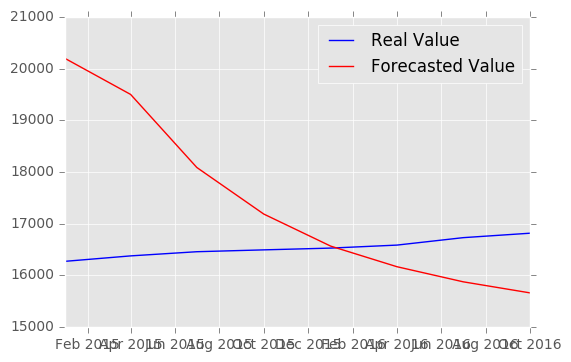

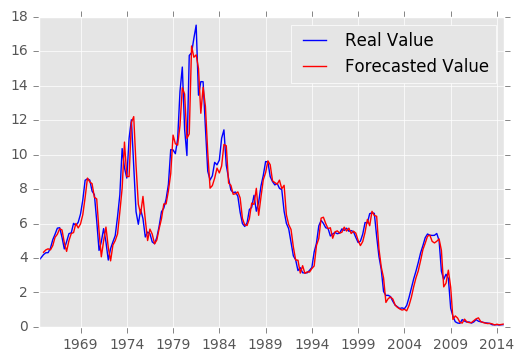

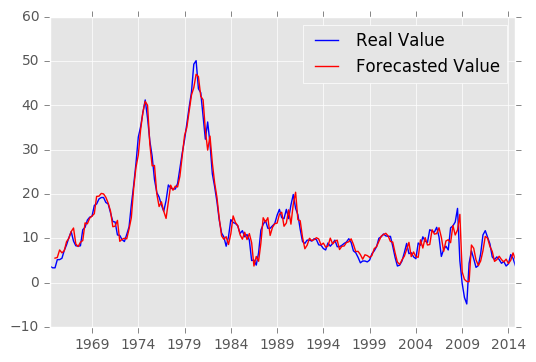

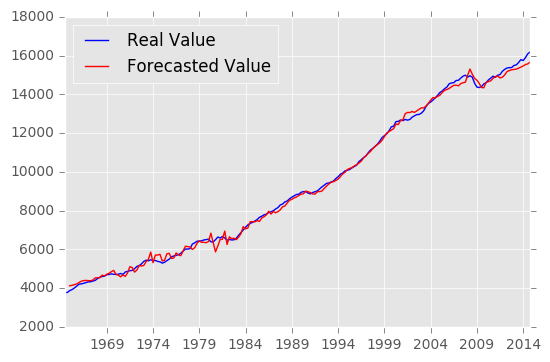

In [59]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [60]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0598
Epoch 2/600
0s - loss: 0.7907
Epoch 3/600
0s - loss: 0.6412
Epoch 4/600
0s - loss: 0.5109
Epoch 5/600
0s - loss: 0.4108
Epoch 6/600
0s - loss: 0.3454
Epoch 7/600
0s - loss: 0.3027
Epoch 8/600
0s - loss: 0.2693
Epoch 9/600
0s - loss: 0.2421
Epoch 10/600
0s - loss: 0.2175
Epoch 11/600
0s - loss: 0.1970
Epoch 12/600
0s - loss: 0.1794
Epoch 13/600
0s - loss: 0.1660
Epoch 14/600
0s - loss: 0.1535
Epoch 15/600
0s - loss: 0.1440
Epoch 16/600
0s - loss: 0.1367
Epoch 17/600
0s - loss: 0.1305
Epoch 18/600
0s - loss: 0.1237
Epoch 19/600
0s - loss: 0.1178
Epoch 20/600
0s - loss: 0.1144
Epoch 21/600
0s - loss: 0.1101
Epoch 22/600
0s - loss: 0.1051
Epoch 23/600
0s - loss: 0.1007
Epoch 24/600
0s - loss: 0.0973
Epoch 25/600
0s - loss: 0.0926
Epoch 26/600
0s - loss: 0.0888
Epoch 27/600
0s - loss: 0.0860
Epoch 28/600
0s - loss: 0.0832
Epoch 29/600
0s - loss: 0.0788
Epoch 30/600
0s - loss: 0.0784
Epoch 31/600
0s - loss: 0.0732
Epoch 32/600
0s - loss: 0.0706
Epoch 33/600
0s -

{'rmse': 0.87863668686154728, 'mae': 0.58728864698188943, 'mse': 0.77200242749903669}
{'rmse': 7.9849549532439701, 'mae': 5.9089271893965645, 'mse': 63.759505605335413}
{'rmse': 1589.6586840785133, 'mae': 1217.3350309763375, 'mse': 2527014.7318662303}


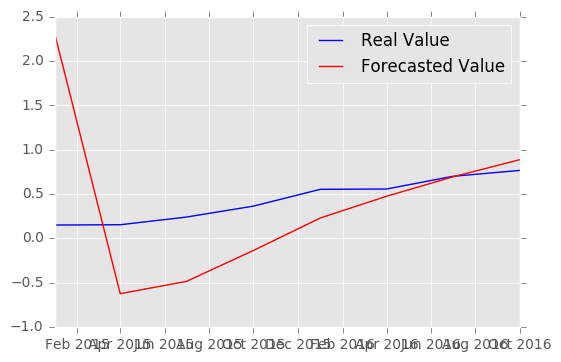

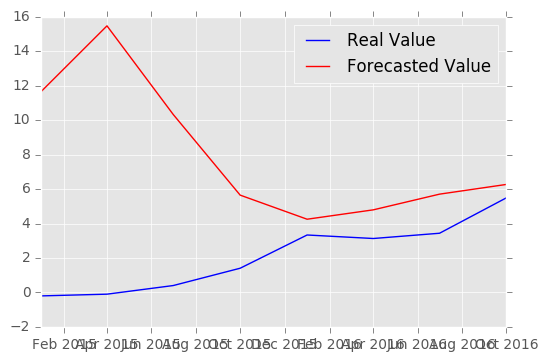

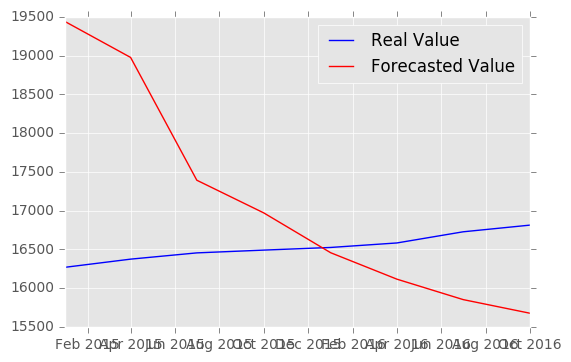

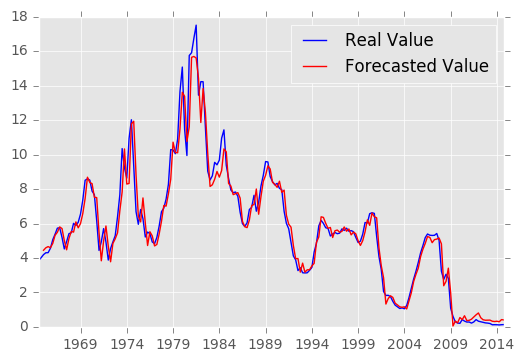

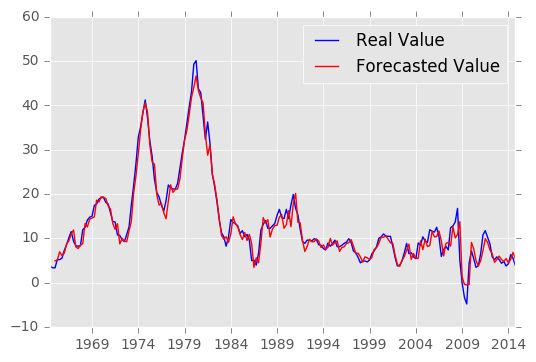

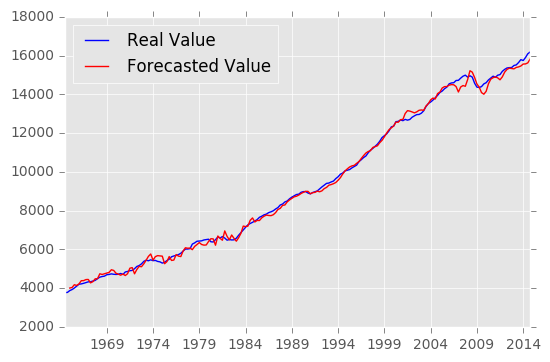

In [61]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [62]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [63]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [64]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.1536
Epoch 2/200
0s - loss: 1.0144
Epoch 3/200
0s - loss: 1.0094
Epoch 4/200
0s - loss: 1.0095
Epoch 5/200
0s - loss: 1.0060
Epoch 6/200
0s - loss: 1.0051
Epoch 7/200
0s - loss: 1.0044
Epoch 8/200
0s - loss: 1.0028
Epoch 9/200
0s - loss: 1.0033
Epoch 10/200
0s - loss: 1.0024
Epoch 11/200
0s - loss: 1.0012
Epoch 12/200
0s - loss: 1.0000
Epoch 13/200
0s - loss: 0.9998
Epoch 14/200
0s - loss: 1.0027
Epoch 15/200
0s - loss: 0.9975
Epoch 16/200
0s - loss: 0.9999
Epoch 17/200
0s - loss: 0.9967
Epoch 18/200
0s - loss: 1.0000
Epoch 19/200
0s - loss: 0.9966
Epoch 20/200
0s - loss: 0.9969
Epoch 21/200
0s - loss: 0.9932
Epoch 22/200
0s - loss: 0.9949
Epoch 23/200
0s - loss: 0.9951
Epoch 24/200
0s - loss: 0.9919
Epoch 25/200
0s - loss: 0.9937
Epoch 26/200
0s - loss: 0.9935
Epoch 27/200
0s - loss: 0.9936
Epoch 28/200
0s - loss: 0.9925
Epoch 29/200
0s - loss: 0.9912
Epoch 30/200
0s - loss: 0.9915
Epoch 31/200
0s - loss: 0.9898
Epoch 32/200
0s - loss: 0.9889
Epoch 33/200
0s -

{'rmse': 0.57254319213043692, 'mae': 0.53374115807755862, 'mse': 0.32780570685491039}
{'rmse': 1.7708852224036804, 'mae': 1.317105626868178, 'mse': 3.1360344709277324}
{'rmse': 34.590866090877057, 'mae': 25.3214313528938, 'mse': 1196.5280169169882}


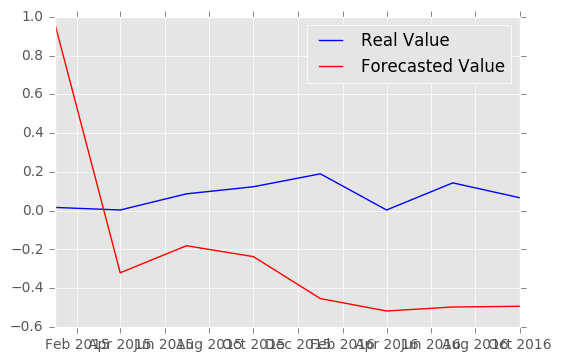

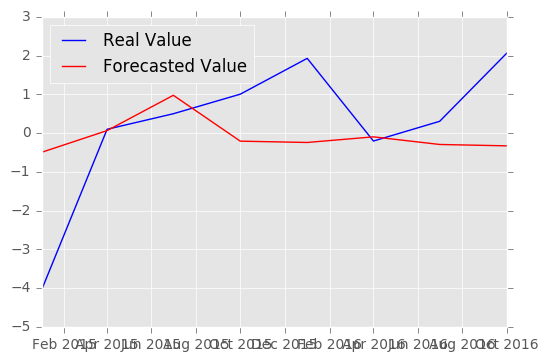

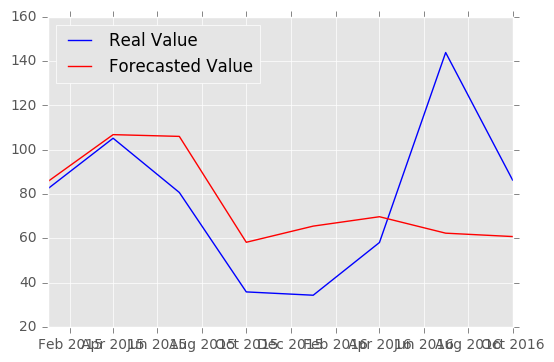

In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'rmse': 1.2284828759503794, 'mae': 0.99060877059245933, 'mse': 1.5091701765033152}
{'rmse': 2.6150618679369177, 'mae': 2.1949894817366382, 'mse': 6.8385485731377216}
{'rmse': 50.241197550344296, 'mae': 36.979938319652092, 'mse': 2524.177931292722}


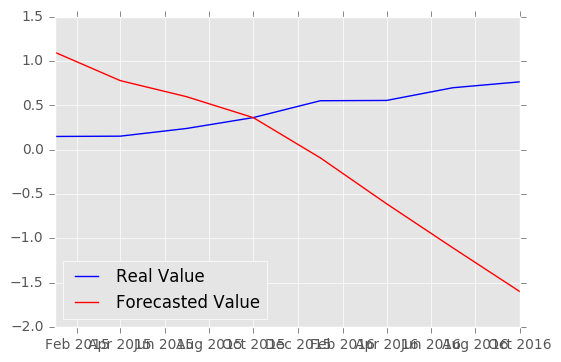

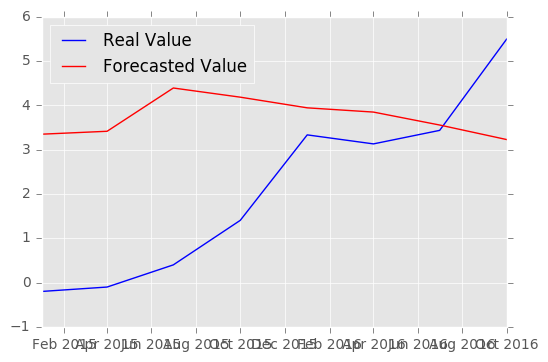

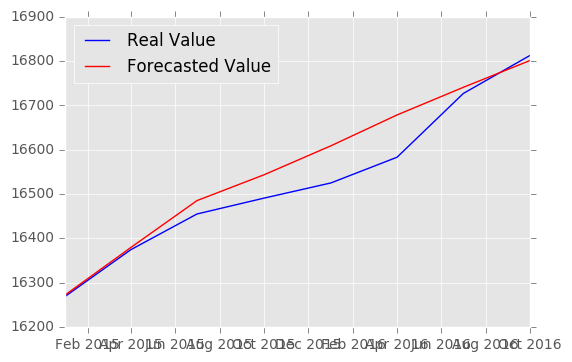

In [66]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [67]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0836
Epoch 2/200
0s - loss: 1.0040
Epoch 3/200
0s - loss: 1.0034
Epoch 4/200
0s - loss: 1.0013
Epoch 5/200
0s - loss: 1.0031
Epoch 6/200
0s - loss: 1.0031
Epoch 7/200
0s - loss: 1.0026
Epoch 8/200
0s - loss: 1.0000
Epoch 9/200
0s - loss: 0.9999
Epoch 10/200
0s - loss: 0.9984
Epoch 11/200
0s - loss: 0.9999
Epoch 12/200
0s - loss: 0.9988
Epoch 13/200
0s - loss: 0.9975
Epoch 14/200
0s - loss: 0.9960
Epoch 15/200
0s - loss: 0.9944
Epoch 16/200
0s - loss: 0.9950
Epoch 17/200
0s - loss: 0.9932
Epoch 18/200
0s - loss: 0.9952
Epoch 19/200
0s - loss: 0.9918
Epoch 20/200
0s - loss: 0.9927
Epoch 21/200
0s - loss: 0.9924
Epoch 22/200
0s - loss: 0.9906
Epoch 23/200
0s - loss: 0.9879
Epoch 24/200
0s - loss: 0.9911
Epoch 25/200
0s - loss: 0.9918
Epoch 26/200
0s - loss: 0.9857
Epoch 27/200
0s - loss: 0.9885
Epoch 28/200
0s - loss: 0.9855
Epoch 29/200
0s - loss: 0.9863
Epoch 30/200
0s - loss: 0.9844
Epoch 31/200
0s - loss: 0.9839
Epoch 32/200
0s - loss: 0.9805
Epoch 33/200
0s -

{'rmse': 0.56161252887962598, 'mae': 0.50427473453986837, 'mse': 0.31540863259456869}
{'rmse': 1.3468026625443807, 'mae': 1.0041187444741917, 'mse': 1.813877411836633}
{'rmse': 35.839075788858111, 'mae': 28.611755300179016, 'mse': 1284.4393533995158}


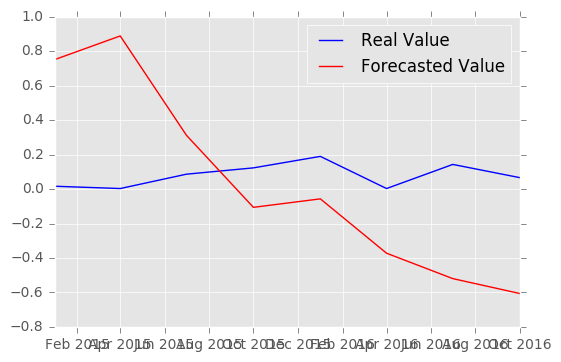

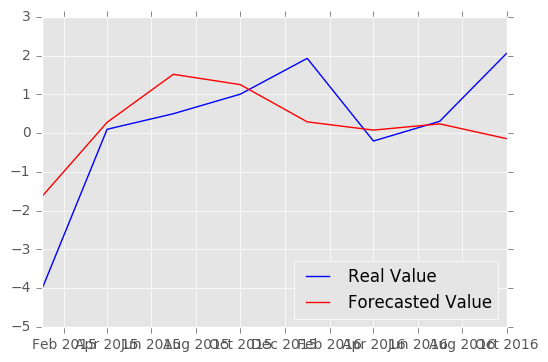

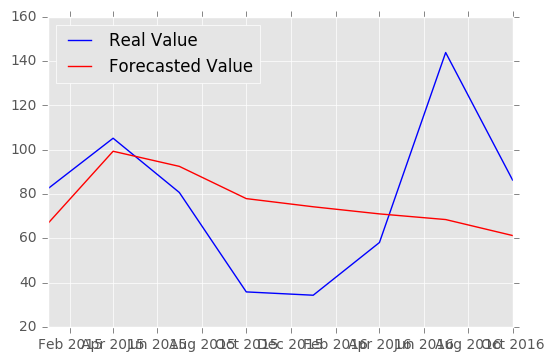

In [68]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'rmse': 1.239913013801192, 'mae': 1.1077724953632502, 'mse': 1.5373842817935552}
{'rmse': 2.6720544623121416, 'mae': 2.4699532645518363, 'mse': 7.1398750495622281}
{'rmse': 42.809209340643015, 'mae': 32.746493501251052, 'mse': 1832.628404370997}


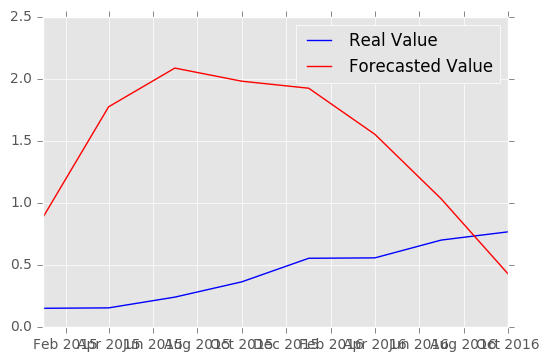

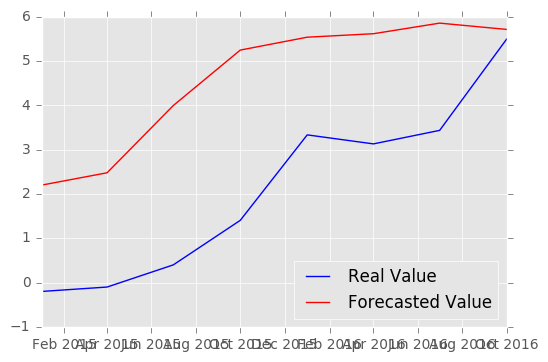

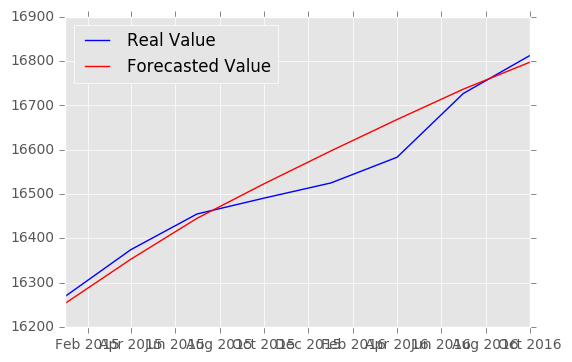

In [69]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [70]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0647
Epoch 2/200
0s - loss: 1.0239
Epoch 3/200
0s - loss: 1.0130
Epoch 4/200
0s - loss: 1.0096
Epoch 5/200
0s - loss: 1.0140
Epoch 6/200
0s - loss: 1.0112
Epoch 7/200
0s - loss: 1.0099
Epoch 8/200
0s - loss: 1.0024
Epoch 9/200
0s - loss: 1.0153
Epoch 10/200
0s - loss: 1.0159
Epoch 11/200
0s - loss: 1.0126
Epoch 12/200
0s - loss: 1.0088
Epoch 13/200
0s - loss: 0.9945
Epoch 14/200
0s - loss: 1.0064
Epoch 15/200
0s - loss: 0.9920
Epoch 16/200
0s - loss: 1.0069
Epoch 17/200
0s - loss: 0.9982
Epoch 18/200
0s - loss: 1.0067
Epoch 19/200
0s - loss: 1.0197
Epoch 20/200
0s - loss: 1.0120
Epoch 21/200
0s - loss: 1.0095
Epoch 22/200
0s - loss: 1.0086
Epoch 23/200
0s - loss: 1.0022
Epoch 24/200
0s - loss: 0.9965
Epoch 25/200
0s - loss: 0.9909
Epoch 26/200
0s - loss: 1.0003
Epoch 27/200
0s - loss: 0.9983
Epoch 28/200
0s - loss: 1.0027
Epoch 29/200
0s - loss: 0.9959
Epoch 30/200
0s - loss: 1.0088
Epoch 31/200
0s - loss: 1.0015
Epoch 32/200
0s - loss: 1.0037
Epoch 33/200
0s -

{'rmse': 0.1511738090847484, 'mae': 0.10930135525398875, 'mse': 0.022853520553191953}
{'rmse': 1.5826292510299251, 'mae': 1.1443804438067002, 'mse': 2.5047153462155416}
{'rmse': 34.372552970612233, 'mae': 25.144032158600691, 'mse': 1181.472397717544}


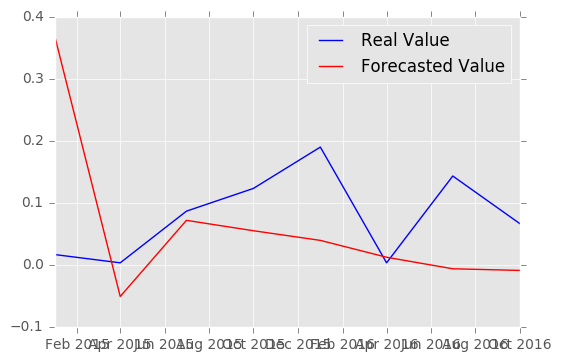

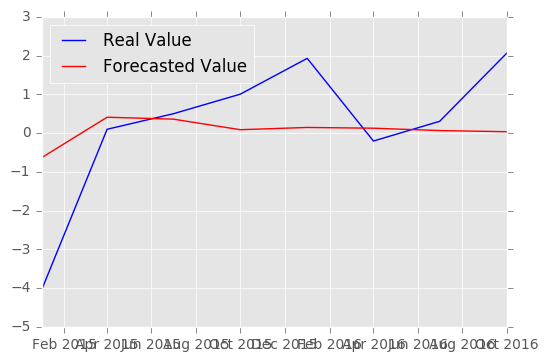

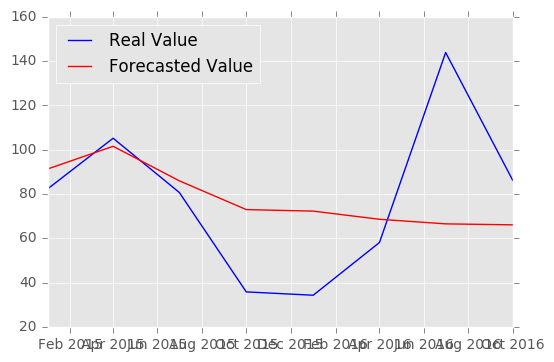

In [71]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'rmse': 0.21735179097443508, 'mae': 0.18933929916925407, 'mse': 0.047241801039794515}
{'rmse': 2.4944217646204496, 'mae': 2.1887393221364775, 'mse': 6.2221399398121982}
{'rmse': 49.368114579562651, 'mae': 34.387637692862654, 'mse': 2437.210737140826}


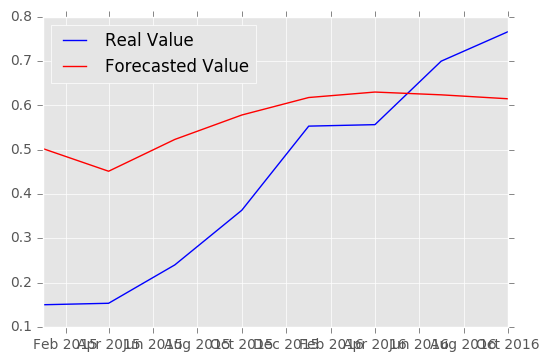

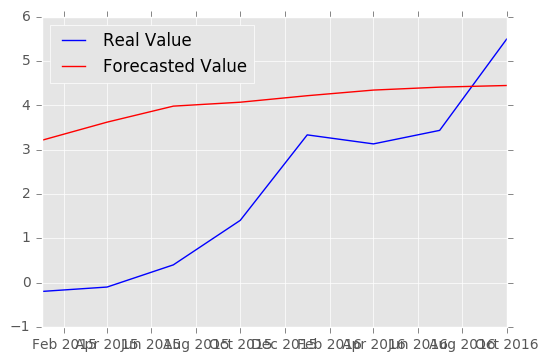

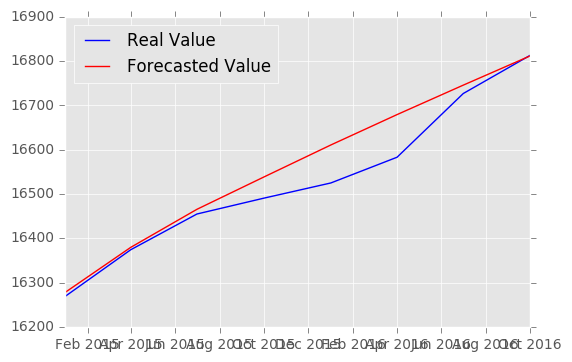

In [72]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid Full

In [73]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [74]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0008
Epoch 2/500
0s - loss: 0.8414
Epoch 3/500
0s - loss: 0.6913
Epoch 4/500
0s - loss: 0.5438
Epoch 5/500
0s - loss: 0.4341
Epoch 6/500
0s - loss: 0.3664
Epoch 7/500
0s - loss: 0.3286
Epoch 8/500
0s - loss: 0.3041
Epoch 9/500
0s - loss: 0.2835
Epoch 10/500
0s - loss: 0.2662
Epoch 11/500
0s - loss: 0.2495
Epoch 12/500
0s - loss: 0.2352
Epoch 13/500
0s - loss: 0.2239
Epoch 14/500
0s - loss: 0.2133
Epoch 15/500
0s - loss: 0.2077
Epoch 16/500
0s - loss: 0.2010
Epoch 17/500
0s - loss: 0.1961
Epoch 18/500
0s - loss: 0.1941
Epoch 19/500
0s - loss: 0.1894
Epoch 20/500
0s - loss: 0.1874
Epoch 21/500
0s - loss: 0.1850
Epoch 22/500
0s - loss: 0.1826
Epoch 23/500
0s - loss: 0.1804
Epoch 24/500
0s - loss: 0.1787
Epoch 25/500
0s - loss: 0.1759
Epoch 26/500
0s - loss: 0.1739
Epoch 27/500
0s - loss: 0.1723
Epoch 28/500
0s - loss: 0.1699
Epoch 29/500
0s - loss: 0.1681
Epoch 30/500
0s - loss: 0.1663
Epoch 31/500
0s - loss: 0.1645
Epoch 32/500
0s - loss: 0.1617
Epoch 33/500
0s -

{'rmse': 2.2310006617951776, 'mae': 1.9513273631726544, 'mse': 4.9773639529305216}
{'rmse': 5.6912538226595046, 'mae': 5.2691536373463776, 'mse': 32.390370073936424}
{'rmse': 202.89260630011395, 'mae': 107.74600137004177, 'mse': 41165.409691253037}


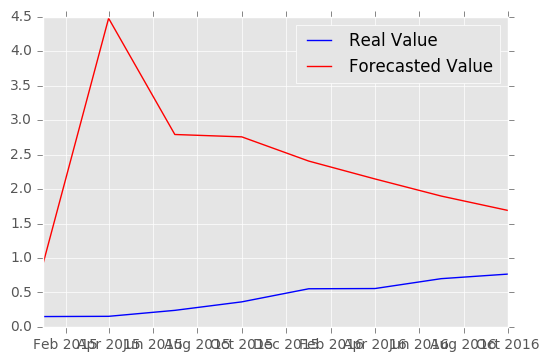

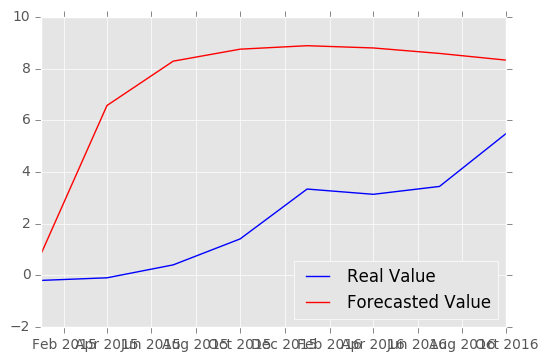

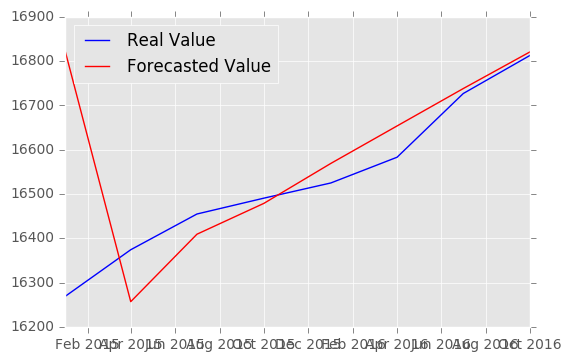

In [75]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [76]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0140
Epoch 2/500
0s - loss: 0.7428
Epoch 3/500
0s - loss: 0.5524
Epoch 4/500
0s - loss: 0.4298
Epoch 5/500
0s - loss: 0.3752
Epoch 6/500
0s - loss: 0.3565
Epoch 7/500
0s - loss: 0.3455
Epoch 8/500
0s - loss: 0.3339
Epoch 9/500
0s - loss: 0.3235
Epoch 10/500
0s - loss: 0.3084
Epoch 11/500
0s - loss: 0.2943
Epoch 12/500
0s - loss: 0.2795
Epoch 13/500
0s - loss: 0.2629
Epoch 14/500
0s - loss: 0.2464
Epoch 15/500
0s - loss: 0.2298
Epoch 16/500
0s - loss: 0.2147
Epoch 17/500
0s - loss: 0.2015
Epoch 18/500
0s - loss: 0.1887
Epoch 19/500
0s - loss: 0.1779
Epoch 20/500
0s - loss: 0.1673
Epoch 21/500
0s - loss: 0.1587
Epoch 22/500
0s - loss: 0.1500
Epoch 23/500
0s - loss: 0.1423
Epoch 24/500
0s - loss: 0.1348
Epoch 25/500
0s - loss: 0.1278
Epoch 26/500
0s - loss: 0.1215
Epoch 27/500
0s - loss: 0.1161
Epoch 28/500
0s - loss: 0.1108
Epoch 29/500
0s - loss: 0.1070
Epoch 30/500
0s - loss: 0.1036
Epoch 31/500
0s - loss: 0.0997
Epoch 32/500
0s - loss: 0.0982
Epoch 33/500
0s -

{'rmse': 3.5941645404097895, 'mae': 3.5084193541072697, 'mse': 12.918018743539115}
{'rmse': 10.741289389041428, 'mae': 10.229878960114188, 'mse': 115.37529773913397}
{'rmse': 203.54245344010602, 'mae': 132.82007734787953, 'mse': 41429.530352417729}


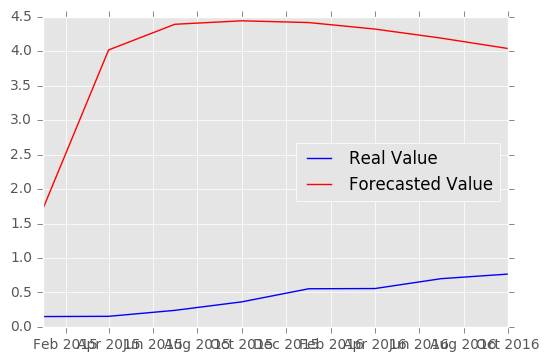

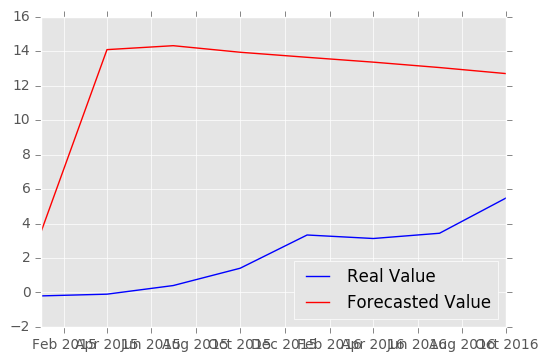

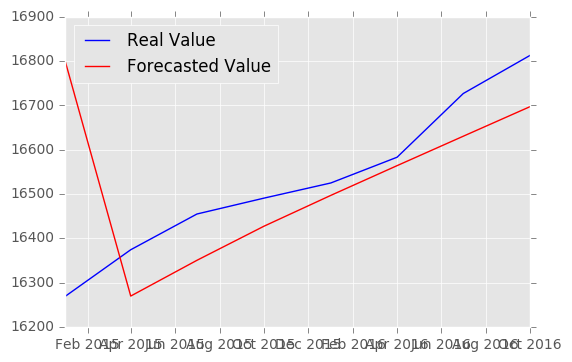

In [77]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

C DropOut

In [78]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1252
Epoch 2/500
0s - loss: 1.0096
Epoch 3/500
0s - loss: 0.9847
Epoch 4/500
0s - loss: 0.9616
Epoch 5/500
0s - loss: 0.9414
Epoch 6/500
0s - loss: 0.9133
Epoch 7/500
0s - loss: 0.8710
Epoch 8/500
0s - loss: 0.8582
Epoch 9/500
0s - loss: 0.7798
Epoch 10/500
0s - loss: 0.7886
Epoch 11/500
0s - loss: 0.7130
Epoch 12/500
0s - loss: 0.6572
Epoch 13/500
0s - loss: 0.6635
Epoch 14/500
0s - loss: 0.5986
Epoch 15/500
0s - loss: 0.5737
Epoch 16/500
0s - loss: 0.5913
Epoch 17/500
0s - loss: 0.5742
Epoch 18/500
0s - loss: 0.5498
Epoch 19/500
0s - loss: 0.5767
Epoch 20/500
0s - loss: 0.5454
Epoch 21/500
0s - loss: 0.5333
Epoch 22/500
0s - loss: 0.5451
Epoch 23/500
0s - loss: 0.5218
Epoch 24/500
0s - loss: 0.4882
Epoch 25/500
0s - loss: 0.5081
Epoch 26/500
0s - loss: 0.5267
Epoch 27/500
0s - loss: 0.4930
Epoch 28/500
0s - loss: 0.4949
Epoch 29/500
0s - loss: 0.5046
Epoch 30/500
0s - loss: 0.5042
Epoch 31/500
0s - loss: 0.4845
Epoch 32/500
0s - loss: 0.5068
Epoch 33/500
0s -

{'rmse': 3.1105984421464723, 'mae': 3.0952875591893529, 'mse': 9.6758226682840593}
{'rmse': 6.2936767875961461, 'mae': 5.7985232355029996, 'mse': 39.610367506726547}
{'rmse': 79.244827073584105, 'mae': 69.726590198310532, 'mse': 6279.7426179222475}


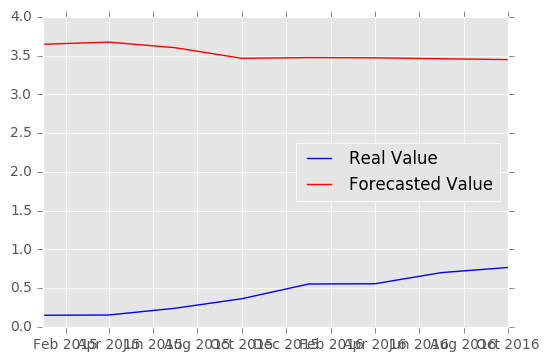

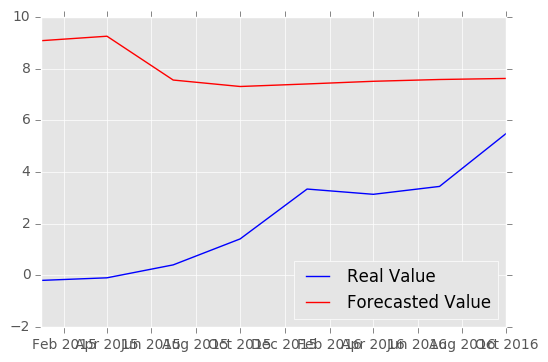

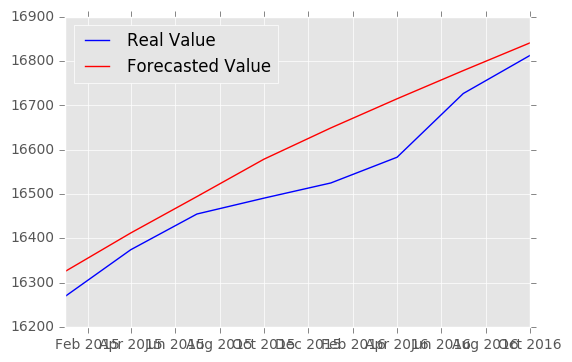

In [79]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])